In [1]:
import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import urllib
from skimage.transform import resize
from matplotlib.image import imread
import os
from IPython.display import display
from skimage import io as io_url
import cv2
import numpy as np
from PIL import Image

In [2]:
# Create image widgets
image3_spatial = widgets.Image(format='png', width=500, height=500, description='Spatial')
image3_freq    = widgets.Image(format='png', width=500, height=500, description='Frequency')
sidebyside     = widgets.HBox([image3_spatial, image3_freq])

# Create slider/select widgets
slider_inner   = widgets.FloatSlider(value=0,      min=0, max=1,      step=0.01, description='Inner radius')
slider_outer   = widgets.FloatSlider(value=1.44/2, min=0, max=1.44/2, step=0.01, description='Outer radius')

buf            = io.BytesIO()

orig_img = io_url.imread('https://img2.zergnet.com/2309662_300.jpg')
orig_img = np.mean(orig_img, -1)

x = np.fft.fftfreq(orig_img.shape[0]);
y = np.fft.fftfreq(orig_img.shape[1]);

xv, yv = np.meshgrid(x, y)
xv = np.fft.fftshift(xv)
yv = np.fft.fftshift(yv)

def filter_frequency(orig_img, mask):
    """
    You need to remove frequency based on the given mask.
    Params:
        orig_img: numpy image
        mask: same shape with orig_img indicating which frequency hold or remove
    Output:
        f_img: frequency image after applying mask
        img: image after applying mask
    """
    f_img = np.fft.fft2(orig_img)
    f_img_shifted = np.fft.fftshift(f_img)
    f_img_filtered = f_img_shifted * mask
    f_img_filtered_shifted = np.fft.ifftshift(f_img_filtered)
    img = np.abs(np.fft.ifft2(f_img_filtered_shifted))

    return np.abs(f_img_filtered), img


def on_value_change3(change):
    mask = (np.sqrt(xv**2 + yv**2) < slider_outer.value) & \
           (np.sqrt(xv**2 + yv**2) >= slider_inner.value)
    mask = np.float32(mask)

    fimg, img = filter_frequency(orig_img, mask)
    buf.seek(0)
    tmp = PIL.Image.fromarray(255*img/(img.max()+0.0001))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_spatial.value = buf.getvalue()

    buf.seek(0)
    tmp = PIL.Image.fromarray(255*np.log(0.0001*fimg + 1))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_freq.value = buf.getvalue()


slider_inner.observe(on_value_change3, names='value')
slider_outer.observe(on_value_change3, names='value')

on_value_change3(0)

display(sidebyside)
display(slider_inner)
display(slider_outer)

FloatSlider(value=0.0, description='Inner radius', max=1.0, step=0.01)

FloatSlider(value=0.72, description='Outer radius', max=0.72, step=0.01)

In [3]:
def read_img(img_path, img_size=(512, 512)):
    """
        + Đọc ảnh
        + Chuyển thành grayscale
        + Thay đổi kích thước ảnh thành img_size
    """
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, img_size)
    return img


def create_hybrid_img(img1, img2, r):
    """
    Create hydrid image
    Params:
        img1: numpy image 1
        img2: numpy image 2
        r: radius that defines the filled circle of frequency of image 1. Refer to the homework title to know more.
    """
    img1_fft_shifted = np.fft.fftshift(np.fft.fft2(img1))
    img2_fft_shifted = np.fft.fftshift(np.fft.fft2(img2))

    mask1 = np.zeros_like(img1_fft_shifted)
    rows, cols = mask1.shape
    center_row, center_col = int(rows / 2), int(cols / 2)
    y, x = np.ogrid[-center_row:rows - center_row, -center_col:cols - center_col]
    mask1[x*x + y*y <= r*r] = 1

    mask2 = (1 - mask1)
    hybrid_fft_shifted = img1_fft_shifted * mask1 + img2_fft_shifted * mask2
    hybrid_fft = np.fft.ifftshift(hybrid_fft_shifted)

    return np.abs(np.fft.ifft2(hybrid_fft))

(-0.5, 511.5, 511.5, -0.5)

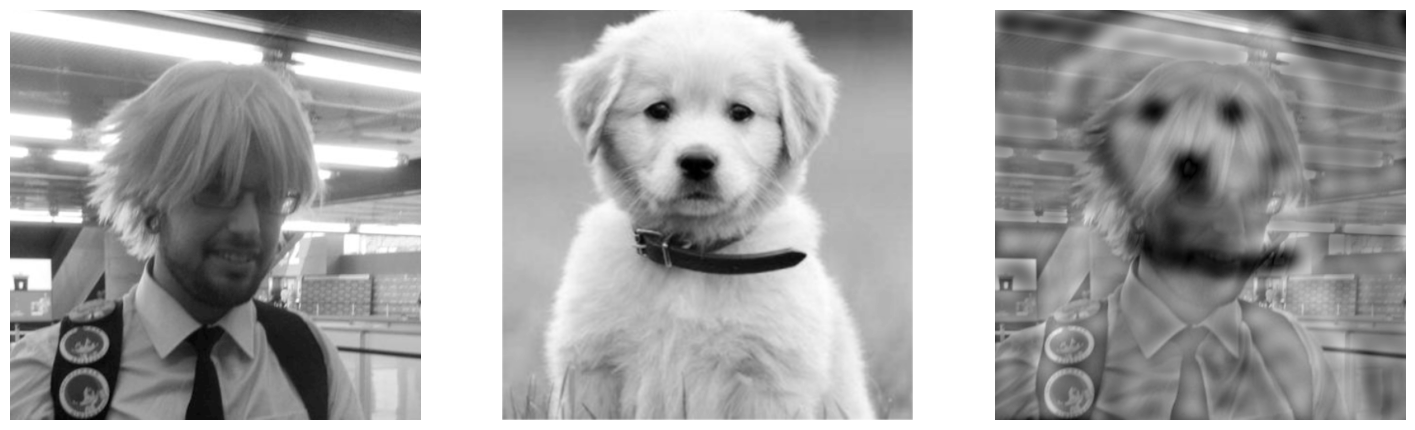

In [6]:
image_1_path = "/content/denji.png" # <-- need to change
image_2_path = "/content/doggy.png" # <-- need to change
img_1 = read_img(image_1_path)
img_2 = read_img(image_2_path)
hybrid_img = create_hybrid_img(img_2, img_1, 14)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
axes[0].imshow(img_1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img_2, cmap="gray")
axes[1].axis("off")
axes[2].imshow(hybrid_img, cmap="gray")
axes[2].axis("off")